# Visualisation of SetTransformer outputs

### 2. Define functions for processing the result tables

In [1]:
import pandas as pd

def read_and_process_table(file_path):
    df = pd.read_csv(file_path, delimiter='\t')
    print(df)

# num_ind_points = 10
# csv_files_holdout_test = [f for f in os.listdir(RESULT_DIRECTORY) if f.endswith('.csv') and "holdout_test" in f and f"indPoints_{num_ind_points}" in f]
# read_and_process_table(RESULT_DIRECTORY+csv_files_holdout_test[0])

In [2]:


def group_matching_probab(file_path):
    df = pd.read_csv(file_path, delimiter='\t')
    # Assuming df is your DataFrame
    df['prediction_correct'] = df['prediction'] == df['y_actual']

    df['fp_prediction'] = (df['prediction'] == 1) & (df['y_actual'] == 0)
    df['fn_prediction'] = (df['prediction'] == 0) & (df['y_actual'] == 1)

  #  print(df)
    
    grouped = (
        df.groupby(['false_negative_rate', 'false_positive_rate'])
        .agg({
            'prediction_correct': 'mean',
            'fp_prediction': 'mean',
            'fn_prediction': 'mean'
        })
        .reset_index()
    )
    
    # Rename columns for clarity if needed
    grouped.rename(
        columns={
            'prediction_correct': 'matching_probability',
            'fp_prediction': 'mean_fp_prediction',
            'fn_prediction': 'mean_fn_prediction'
        },
        inplace=True
    )
    
    return grouped

In [3]:
def generate_tables(grouped):
    tables = []
    
    false_positive_unique = grouped['false_positive_rate'].unique()
    
    # Loop over each unique value in false_positive_rate
    for false_positive_value in false_positive_unique:
        # Filter the rows with this false_positive_rate value
        filtered_df = grouped[grouped['false_positive_rate'] == false_positive_value]
        
        # Optionally, you can add the false_positive_rate as a column in the filtered DataFrame
        filtered_df = filtered_df[['false_negative_rate', 'matching_probability', 'mean_fp_prediction', 'mean_fn_prediction']]
    
        # Append to the tables list
       # print(filtered_df)
        tables.append(filtered_df)
    return tables    

In [4]:
from collections import defaultdict

def find_average_table(csv_files_cross_valid):
    tables_all_folds = defaultdict(list)
    tables_average_folds = defaultdict(pd.DataFrame)
    
    for csv_file in csv_files_cross_valid:
        file_path = RESULT_DIRECTORY + csv_file
        grouped = group_matching_probab(file_path)
        tables = generate_tables(grouped)
        for i in range(len(tables)):
            tables_all_folds[false_posit_uniq[i]].append(tables[i])
    
    for key in tables_all_folds.keys():
        tables = tables_all_folds[key]
        
        # Concatenate all tables into one DataFrame
        combined = pd.concat(tables)
        
        # Group by 'false_negative_rate' and calculate the mean of 'matching_probability'
        average_table = (
            combined.groupby('false_negative_rate', as_index=False)
            .agg({
                'matching_probability': 'mean',
                'mean_fp_prediction': 'mean',
                'mean_fn_prediction': 'mean'
            })
        )
       
        tables_average_folds[key] = average_table
    return tables_average_folds        

In [14]:
import matplotlib.pyplot as plt

def plot_results(column_name, num_ind_points, fp_to_plot, tables_average_folds):
    plt.figure(figsize=(6, 4))
    idx = 0
    for false_posit in tables_average_folds.keys():
        false_positive_value = false_posit_uniq[idx]
        if false_positive_value in fp_to_plot:
            table = tables_average_folds[false_posit]
            plt.scatter(table['false_negative_rate'], table[column_name])
            plt.plot(table['false_negative_rate'], table[column_name], label=f'extra genes rate = {false_positive_value}')
        idx += 1    
    
  #  plt.ylim([0.83, 1])
    plt.xlabel('gene removal rate')
    plt.ylabel('accuracy')
    plt.legend()

    plt.title(f"{column_name} for SetTransformer with {num_ind_points} inducing points")
    plt.ylim([0.8,1.05])
    
    plt.grid(True)
    plt.show()  

In [6]:
import numpy as np

def find_aver_accuracy(table_dict):
    average_arr = []
    for key in table_dict.keys():
        average_arr.append(table_dict[key]['matching_probability'].mean())
    return np.mean(average_arr)    

### 3. Process all the cross-validation tables and find averate across different folds

In [17]:
import os

RESULT_DIRECTORY = "set_transformer/resuls_SetTransformer/"
false_posit_uniq = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
false_negat_uniq = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

def find_accuracies(num_ind_points):
    # List of all csv files with cross_validation results
    csv_files_cross_valid = [f for f in os.listdir(RESULT_DIRECTORY) if f.endswith('.csv') and "cross_valid" in f and f"indPoints_{num_ind_points}" in f and "phenotype_aerob" in f]
    
    csv_files_holdout_test = [f for f in os.listdir(RESULT_DIRECTORY) if f.endswith('.csv') and "holdout_test" in f and f"indPoints_{num_ind_points}" in f and "phenotype_aerob" in f]
    
    grouped = group_matching_probab(RESULT_DIRECTORY+csv_files_holdout_test[0])
    #holdout_test_accur_aver = grouped.loc[(grouped["false_negative_rate"] == 0.0) & (grouped["false_positive_rate"] == 0.0),"matching_probability"].iloc[0]
    holdout_test_accur_aver = grouped['matching_probability'].mean()


    print(f"\nHold-out (test) dataset results for {num_ind_points} inducing points:")
    print(f"Average accuracy: {round(grouped['matching_probability'].mean(),3)};")
    print(f"Average false_positive predictions: {round(grouped['mean_fp_prediction'].mean(),3)};")
    print(f"Average false_negative predictions: {round(grouped['mean_fn_prediction'].mean(),3)}")
    

    
    tables_average_folds = find_average_table(csv_files_cross_valid)
    cross_valid_aver = find_aver_accuracy(tables_average_folds)
    
    #zero_false_pos_table = tables_average_folds[0]
    #cross_valid_aver = zero_false_pos_table.loc[zero_false_pos_table['false_negative_rate'] == 0.0, 'matching_probability'].iloc[0]
    print(f"\nCross-validation accuracy = {round(cross_valid_aver,3)} for {num_ind_points} inducing points")
    return tables_average_folds

### 4. Find average accuracies and plot the results

In [8]:
fp_to_plot = [0, 0.1, 0.2, 0.5]


Hold-out (test) dataset results for 2 inducing points:
Average accuracy: 0.963;
Average false_positive predictions: 0.024;
Average false_negative predictions: 0.013

Cross-validation accuracy = 0.952 for 2 inducing points


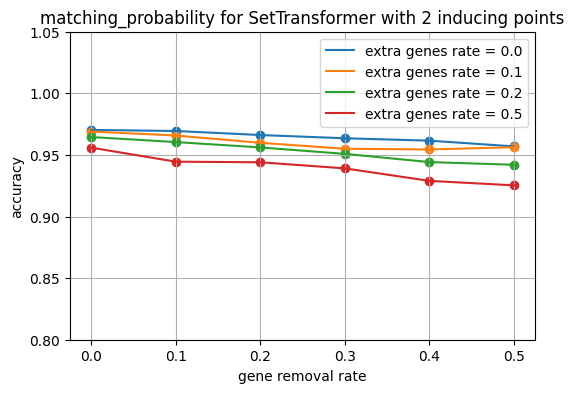

In [29]:
num_ind_points = 2
tables_average_folds = find_accuracies(num_ind_points)
plot_results('matching_probability', num_ind_points, fp_to_plot, tables_average_folds)



#plot_results('mean_fn_prediction', num_ind_points, fp_to_plot, tables_average_folds)


Hold-out (test) dataset results for 5 inducing points:
Average accuracy: 0.969;
Average false_positive predictions: 0.014;
Average false_negative predictions: 0.017

Cross-validation accuracy = 0.958 for 5 inducing points


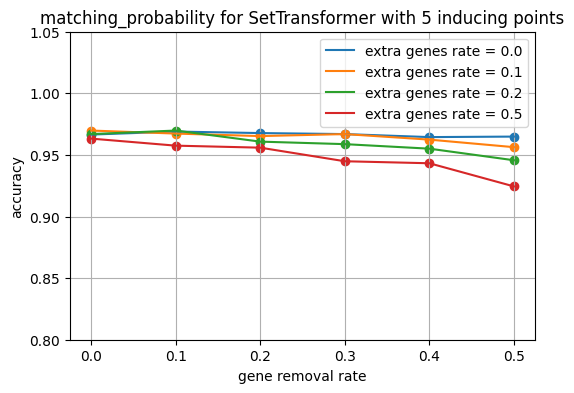

In [31]:
    # def __init__(self, dim_input, num_outputs, dim_output,
            # num_inds=num_inds, dim_hidden=32, num_heads=4, ln=True): 
#batch_size=256

num_ind_points = 5
tables_average_folds = find_accuracies(num_ind_points)
plot_results('matching_probability', num_ind_points, fp_to_plot, tables_average_folds)


Hold-out (test) dataset results for 5 inducing points:
Average accuracy: 0.966;
Average false_positive predictions: 0.014;
Average false_negative predictions: 0.02

Cross-validation accuracy = 0.958 for 5 inducing points


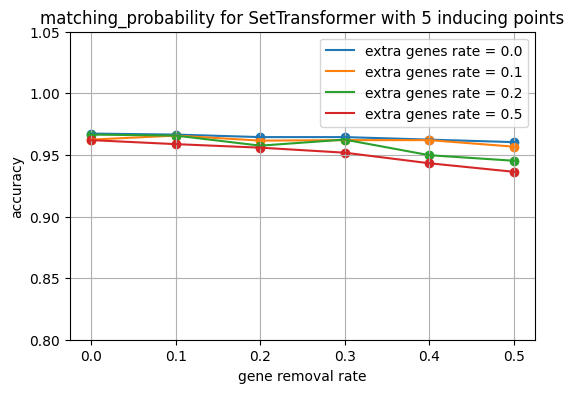

In [27]:
    # def __init__(self, dim_input, num_outputs, dim_output,
    #         num_inds=num_inds, dim_hidden=32, num_heads=4, ln=True):

num_ind_points = 5
tables_average_folds = find_accuracies(num_ind_points)
plot_results('matching_probability', num_ind_points, fp_to_plot, tables_average_folds)


Hold-out (test) dataset results for 20 inducing points:
Average accuracy: 0.963;
Average false_positive predictions: 0.026;
Average false_negative predictions: 0.011

Cross-validation accuracy = 0.949 for 20 inducing points


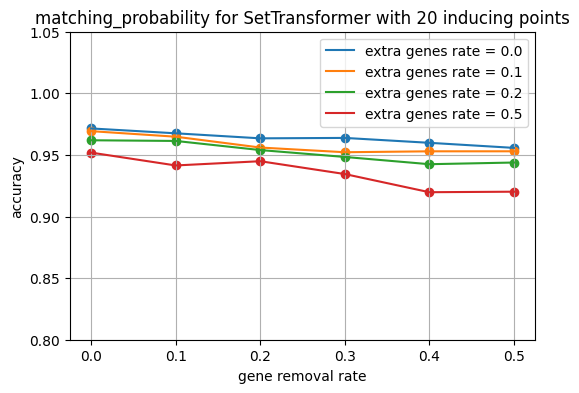

In [28]:
    # def __init__(self, dim_input, num_outputs, dim_output,
    #         num_inds=num_inds, dim_hidden=512, num_heads=4, ln=True):

num_ind_points = 20
tables_average_folds = find_accuracies(num_ind_points)
plot_results('matching_probability', num_ind_points, fp_to_plot, tables_average_folds)